In [1]:
import matplotlib
matplotlib.use('nbagg')
import matplotlib.animation as anm
import matplotlib.pyplot as plt
import math, random                 # 追加
import matplotlib.patches as patches
import numpy as np

In [2]:
class World:
    def __init__(self, time_span, time_interval):
        self.objects = []  
        self.time_span = time_span                  # 追加
        self.time_interval = time_interval          # 追加
        
    def append(self,obj):             # オブジェクトを登録するための関数
        self.objects.append(obj)
    
    def draw(self):            ### fig:world_draw_with_timesapn (1, 10, 21-26, 28-34行目)
        fig = plt.figure(figsize=(4,4))                # 8x8 inchの図を準備
        ax = fig.add_subplot(111)                      # サブプロットを準備
        ax.set_aspect('equal')                         # 縦横比を座標の値と一致させる
        ax.set_xlim(-5,5)                              # X軸を-5m x 5mの範囲で描画
        ax.set_ylim(-5,5)                              # Y軸も同様に
        ax.set_title("$\Sigma_{world}$",fontsize=10)   # 図のタイトルをTeXの形式で埋め込み
        ax.set_xlabel("X",fontsize=10)                 # X軸にラベルを表示
        ax.set_ylabel("Y",fontsize=10)                 # 同じくY軸に
        
        elems = []
        ### FuncAnimationのframes, intervalを変更 ###
        self.ani = anm.FuncAnimation(fig, self.one_step, fargs=(elems, ax),
                                     frames=int(self.time_span/self.time_interval),
                                     interval=int(self.time_interval*1000), repeat=False)

        plt.show()
        
    def one_step(self, i, elems, ax):
        while elems: elems.pop().remove()
        time_str = "t = %.2f[s]" % (self.time_interval*i)    # 時刻として表示する文字列
        elems.append(ax.text(-4.4, 4.5, time_str, fontsize=10))
        for obj in self.objects:
            obj.draw(ax, elems)
            obj.one_step(self.time_interval)                 # 変更

In [3]:
class Robot:
    def __init__(self, pose, agent=None, sensor=None, color="black"):    # 引数を追加
        self.pose = pose  
        self.r = 0.2  
        self.color = color 
        self.agent = agent
        self.sensor = sensor    # 追加
        
    def vec_trans_to_world(self,vec):
        s = math.sin(self.pose[2])  # self.pose[2]はロボットの向き
        c = math.cos(self.pose[2])
        return np.array([[c, -s], 
                        [s, c]]).dot(vec) # 回転行列に引数のベクトルをかけて返す
    
    def pos_trans_to_world(self,pos):
        return self.vec_trans_to_world(pos) + self.pose[0:2]
    
    def draw(self, ax, elems):
        x, y, theta = self.pose                   # 姿勢の変数を分解して3つの変数へ
        xn = x + self.r * math.cos(theta)         #  ロボットの鼻先のx座標 
        yn = y + self.r * math.sin(theta)         #  ロボットの鼻先のy座標 
        elems += ax.plot([x,xn], [y,yn], color=self.color) # ロボットの向きを示す線分の描画
        c = patches.Circle(xy=(x, y), radius=self.r, fill=False, color=self.color) 
        elems.append(ax.add_patch(c))   # 上のpatches.Circleでロボットの胴体を示す円を作ってサブプロットへ登録
        if self.sensor:
            self.sensor.draw(ax, elems, self.pose)
         
    def draw_coordinate_system(self, ax):   
        origin = self.pos_trans_to_world(np.array([0, 0]).T) # ロボット座標系の原点を世界座標系へ
        for v in [[1, 0], [0, 1]]:                           # それぞれロボット座標系のX,Y軸の単位ベクトル
            wv = self.vec_trans_to_world(np.array(v).T)     # 世界座標系へ単位ベクトルを変換
            ax.quiver(origin[0], origin[1], wv[0], wv[1],  # 矢印で単位ベクトルを描画
                angles='xy', scale_units='xy', scale=1, color=self.color)
            
    def func_state_transition(self, nu, omega, time, pose):
        t0 = pose[2]
        nu = random.gauss(nu, nu*0.3)            # 追加
        omega = random.gauss(omega, omega*0.3)   # 追加
        if math.fabs(omega) < 1e-10:
            return pose + np.array( [nu*math.cos(t0), 
                                     nu*math.sin(t0),
                                     omega ] ) * time
        else:
            return pose + np.array( [nu/omega*(math.sin(t0 + omega*time) - math.sin(t0)), 
                                     nu/omega*(-math.cos(t0 + omega*time) + math.cos(t0)),
                                     omega*time ] )

    def one_step(self, time_interval):
        if not self.agent: return
        nu, omega = self.agent.decision()
        self.pose = self.func_state_transition(nu, omega, time_interval, self.pose)
        if self.sensor: self.sensor.data(self.pose)        # 追加

In [4]:
class StaticAgent:
    def __init__(self, nu, omega):
        self.nu = nu
        self.omega = omega
        
    def decision(self):
        return self.nu, self.omega

In [5]:
class Landmark:
    def __init__(self, x, y):
        self.pos = np.array([x, y]).T
        self.id = None
        
    def draw(self, ax, elems):
        c = ax.scatter(self.pos[0], self.pos[1], s=100, marker="*", label="landmarks", color="orange")
        elems.append(c)
        elems.append(ax.text(self.pos[0], self.pos[1], "id:" + str(self.id), fontsize=10))

In [6]:
class Map:
    def __init__(self):       # 空のランドマークのリストを準備
        self.landmarks = []
        
    def append_landmark(self, landmark):       # ランドマークを追加
        landmark.id = len(self.landmarks) + 1  # 追加するランドマークにIDを与える
        self.landmarks.append(landmark)

    def draw(self, ax, elems):                 # 描画（Landmarkのdrawを順に呼び出し）
        for lm in self.landmarks: lm.draw(ax, elems)

    def one_step(self, time_interval):         # ランドマークは動かないので何もしない
        pass

In [7]:
class Camera:
    def __init__(self, env_map):
        self.map = env_map
        self.lastdata = []
        
    def visible(self, distance, direction):  # ランドマークが計測できる条件
        return 0.5 <= distance <= 6.0 and math.fabs(direction) <= math.pi/3
        
    def data(self, cam_pose):
        observed = []
        for lm in self.map.landmarks:
            z = self.relative_polar_pos(cam_pose, lm.pos)
            if self.visible(z[0], z[1]):       # 条件を追加
                observed.append((z, lm.id))   # インデント
            
        self.lastdata = observed 
        return observed   
        
    def relative_polar_pos(self, cam_pose, obj_pos):
        s = math.sin(cam_pose[2])
        c = math.cos(cam_pose[2])
        relative_pos = np.array([[c,  s],
                                 [-s, c]]).dot(obj_pos - cam_pose[0:2])
        
        distance = math.sqrt(relative_pos[0]**2 + relative_pos[1]**2)
        direction = math.atan2(relative_pos[1], relative_pos[0])
        
        return np.array([distance, direction]).T
    
    def draw(self, ax, elems, cam_pose): 
        for lm in self.lastdata:
            x, y, theta = cam_pose
            distance, direction = lm[0]
            lx = x + distance * math.cos(direction + theta)
            ly = y + distance * math.sin(direction + theta)
            elems += ax.plot([x,lx], [y,ly], color="pink")

<IPython.core.display.Javascript object>


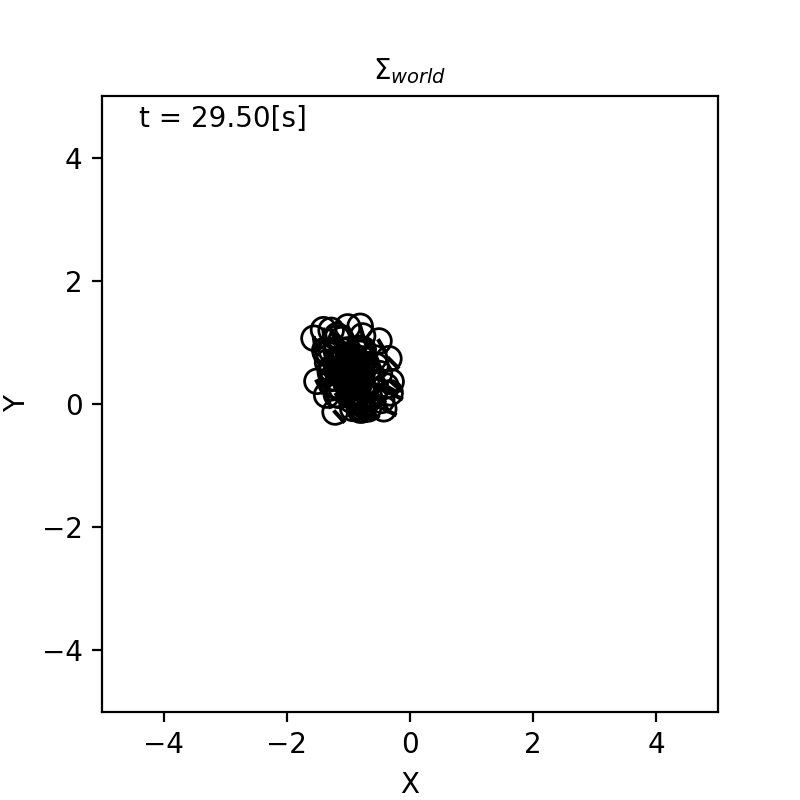

In [8]:
world = World(30, 0.5) 

for i in range(100):
    circling = StaticAgent(0.2, 10.0/180*math.pi)
    r = Robot( np.array([0, 0, 0]).T, sensor=None, agent=circling ) 
    world.append(r)

world.draw()